<a href="https://colab.research.google.com/github/colinmcnamara/Learning_Langchain_Pub/blob/main/NJOY_Pitch_Workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install OpenAI langchain pydantic faiss-gpu colab-env unstructured chromadb tiktoken pdf2image faiss-gpu pypdf pytesseract "unstructured[all-docs]" markdownTable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.5/405.5 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.1/271.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 74.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 198.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [2]:
import colab_env

Mounted at /content/gdrive


In [3]:
!apt-get install poppler-utils tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  poppler-utils tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 4 newly installed, 0 to remove and 16 not upgraded.
Need to get 5,002 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.2 [186 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 5,002 kB in 1s (9,889 kB/s)
Selecting previously unselected package popp

In [4]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import CharacterTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain import OpenAI, VectorDBQA
from langchain.document_loaders import DirectoryLoader
import magic
import os
import nltk
import textwrap

from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain.chat_models import ChatOpenAI
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

llm = OpenAI(temperature=0)
chat = ChatOpenAI(temperature=0)
# os.environ['OPENAI_API_KEY'] = '...'


In [5]:
from langchain.chains import RetrievalQA
from langchain.document_loaders.pdf import PyPDFLoader
from langchain.document_loaders import TextLoader
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import UnstructuredExcelLoader



In [6]:
import unstructured.partition.auto as auto_module
# check whether we have partition_pdf
print(dir(auto_module))


['Callable', 'DataSourceMetadata', 'Dict', 'FILETYPE_TO_MIMETYPE', 'FileType', 'IO', 'List', 'Optional', 'PARTITION_WITH_EXTRAS_MAP', 'STR_TO_FILETYPE', 'Tuple', '__annotations__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_get_partition_with_extras', 'decide_table_extraction', 'dependency_exists', 'detect_filetype', 'exactly_one', 'file_and_type_from_url', 'io', 'is_json_processable', 'logger', 'partition', 'partition_csv', 'partition_doc', 'partition_docx', 'partition_email', 'partition_epub', 'partition_html', 'partition_image', 'partition_json', 'partition_md', 'partition_msg', 'partition_odt', 'partition_org', 'partition_pdf', 'partition_ppt', 'partition_pptx', 'partition_rst', 'partition_rtf', 'partition_text', 'partition_tsv', 'partition_xlsx', 'partition_xml', 'pdf_imports', 'requests']


In [7]:
documents = []
loader = DirectoryLoader('/content/gdrive/MyDrive/Projects/NJOY/', glob='**/*.pdf')


In [8]:
#!pip install "unstructured[all-docs]"

In [9]:
documents = loader.load()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [10]:
#see how many documents are loaded
len (documents)

42

In [11]:
#text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
text_splitter = RecursiveCharacterTextSplitter(
    # Set a reasonable chunk size.
    chunk_size = 1000,
    chunk_overlap  = 20,
    length_function = len,
    separators=["\n\n", "\n", " ", ""]
)

In [12]:
texts = text_splitter.split_documents(documents)

In [13]:
embeddings = OpenAIEmbeddings(openai_api_key=os.environ['OPENAI_API_KEY'])

In [14]:
docsearch = Chroma.from_documents(texts, embeddings)

In [15]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(max_tokens=2048), chain_type="stuff", vectorstore=docsearch)

/usr/local/lib/python3.10/dist-packages/langchain/chains/retrieval_qa/base.py:251: UserWarning: `VectorDBQA` is deprecated - please use `from langchain.chains import RetrievalQA`
  warnings.warn(


In [16]:
query = "What data comes from the summary?"
qa.run(query)

' The summary provides data on revenue, cost of goods sold, product and shipping costs, and overhead expenses per month.'

In [17]:
query = "write an investment brief from this data. If the data is not sufficient, specify what data is needed"
qa.run(query)

' The data provided is not sufficient to write an investment brief. Additional data would be needed such as projections of revenue, net income, and cash flow. Additionally, more detailed information on the market, competitors, and strategy would be needed.'

In [18]:
query = "what benefits does NJOY bring?"
qa.run(query)

' NJOY brings health benefits, great taste, multiple studies and patents, a secure and reliable delivery system, and easy accessibility to consumers. It also uses nano-technology to remove the foul taste that comes with higher concentrations of apple cider vinegar, allowing it to deliver a more enjoyable and palatable ACV beverage without compromising on the health benefits associated with apple cider vinegar. Additionally, NJOY could be an attractive acquisition target for larger beverage companies, providing them with a successful and established brand in the health-focused beverage market.'

In [19]:
query = "Describe key benefits that NJOY bring to investors"
qa.run(query)

' NJOY brings investors a secure and reliable way to deliver products to customers, functional benefits that make them attractive to health-conscious consumers, studies that have shown beneficial effects of NJOY on health, a patented process, method, seal, and delivery system that provides a defensible advantage, wide distribution that makes NJOY easily accessible to consumers, and the potential to be an attractive acquisition target for larger beverage companies.'

In [20]:
query = "what is the return on investment for instituational investors with a goal of 5x profitability?"
qa.run(query)

' The return on investment for institutional investors with a goal of 5x profitability is $7,133,737 for the fifth year.'

# let's output this to markdown


In [21]:
import os

# Initialize an empty dictionary to store the results
results_dict = {}

# Execute LangChain queries and store the results in the dictionary
queries = [
    "what problem is NJOY apple cider vinegar beverage solving for the customer? Expand into multiple paragraphs",
    "Describe the NJOY Apple Cider Vinegar Drink as a solution, Highlight its unique selling points (e.g., taste, health benefits)?"
]

for i, query in enumerate(queries):
    result = qa({"query": query})
    results_dict[f"Query {i + 1}"] = result['result']

# Convert the dictionary to a Markdown formatted string
markdown_output = ""
for key, value in results_dict.items():
    markdown_output += f"## {key}\n\n{value}\n\n"

# Save the Markdown formatted string to a file
with open("output.md", "w") as f:
    f.write(markdown_output)

# Print the Markdown formatted string to the console
print(markdown_output)

## Query 1

 NJOY Apple Cider Vinegar Drink is the perfect choice for those who want to enjoy a delicious and healthy beverage without compromising on taste. This beverage solves the problem of not being able to enjoy a tasty beverage that is also good for one's health. By offering a solution that satisfies both health-conscious customers and those looking for delicious drinks, NJOY is able to capture a larger market share. The patent used for NJOY, USPTO Patent 10,123,456, and NJOY's observance of procedural decorum to ensure limited risks and a strong legal defense, further support this solution. NJOY is also able to offer a unique process, method, seal, and delivery system that are not available with other products. This further enables customers to enjoy the beverage in a way that is both convenient and secure. By providing a product that meets customer needs in both taste and health, NJOY is able to offer an attractive solution to those looking for a beverage that can provide both

#saving to markdown output as well as display it

In [22]:
import os

# Initialize an empty dictionary to store the results
results_dict = {}

# Execute LangChain queries and store the results in the dictionary
queries = [
    "what problem is NJOY apple cider vinegar beverage solving for the customer? Expand into multiple paragraphs",
    "Describe the NJOY Apple Cider Vinegar Drink as a solution, Highlight its unique selling points (e.g., taste, health benefits)?"
]

for i, query in enumerate(queries):
    result = qa({"query": query})
    results_dict[query] = result['result']

# Convert the dictionary to a Markdown formatted string
markdown_output = ""
for key, value in results_dict.items():
    markdown_output += f"## {key}\n\n{value}\n\n"

# Save the Markdown formatted string to a file
with open("output.md", "w") as f:
    f.write(markdown_output)

# Print the Markdown formatted string to the console
print(markdown_output)

## what problem is NJOY apple cider vinegar beverage solving for the customer? Expand into multiple paragraphs

 NJOY Apple Cider Vinegar Drink is the perfect choice for those who want to enjoy a delicious and healthy beverage without compromising on taste. The product is designed to provide customers with an option that is both healthy and tasty, without needing to sacrifice one for the other. It is a natural and functional beverage that offers a variety of health benefits, such as aiding digestion, reducing inflammation, and balancing pH levels. Additionally, it is also free of artificial sweeteners, preservatives, and other additives, furthering its appeal as a healthy option. As consumer interest in natural and functional beverages continues to increase, NJOY Apple Cider Vinegar Drink is well-positioned to capture a larger market share. By leveraging their unique patent, process, and delivery system, NJOY is able to provide a product that is both healthy and delicious, allowing cus

#let's do some file operations, changing the location they are saved to to:
/content/gdrive/MyDrive/Projects/NJOY/tool_output/

In [23]:
import os
from datetime import datetime

output_directory = "/content/gdrive/MyDrive/Projects/NJOY/tool_output/"

# Check if output.md exists
output_file_path = os.path.join(output_directory, "output.md")
if os.path.exists(output_file_path):
    # Get the current date and time
    now = datetime.now()
    timestamp = now.strftime("%Y-%m-%d-%H-%M-%S")

    # Rename the existing output.md file
    os.rename(output_file_path, os.path.join(output_directory, f"output-{timestamp}.md"))

# Initialize an empty dictionary to store the results
results_dict = {}

# Execute LangChain queries and store the results in the dictionary
queries = [
    "what problem is NJOY apple cider vinegar beverage solving for the customer? Expand into multiple paragraphs",
    "Describe the NJOY Apple Cider Vinegar Drink as a solution, Highlight its unique selling points (e.g., taste, health benefits)?"
]

for i, query in enumerate(queries):
    result = qa({"query": query})
    results_dict[query] = result['result']

# Convert the dictionary to a Markdown formatted string
markdown_output = ""
for key, value in results_dict.items():
    markdown_output += f"## {key}\n\n{value}\n\n"

# Save the Markdown formatted string to a new output.md file
with open(output_file_path, "w") as f:
    f.write(markdown_output)

# Print the Markdown formatted string to the console
print(markdown_output)

## what problem is NJOY apple cider vinegar beverage solving for the customer? Expand into multiple paragraphs



NJOY Apple Cider Vinegar Drink is designed to be the perfect solution for those who want to enjoy a healthy beverage without compromising on taste. The beverage is made with natural ingredients and provides a range of health benefits, such as aiding digestion, boosting immunity, and helping to regulate blood sugar levels. The beverage also contains a patented process and delivery system that helps to ensure limited risks and a strong legal defense. This unique process and delivery system work together to provide a beverage that is both nutritious and delicious. As such, NJOY Apple Cider Vinegar Drink is the perfect choice for those who want to drink something that is both healthy and enjoyable.

## Describe the NJOY Apple Cider Vinegar Drink as a solution, Highlight its unique selling points (e.g., taste, health benefits)?

 NJOY Apple Cider Vinegar Drink provides a great-t

### Conversational Chain

In [24]:
from langchain import ConversationChain

In [25]:
query = "what is the return on investment for instituational investors with a goal of 5x profitability?"
qa.run(query)

' If the company receives the $5,000,000.00 investment, institutional investors with a goal of 5x profitability can expect to receive a share of $7,133,737 by the year 2026.'

# Sources

In [26]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what is the NJOY value proposition?"
result = qa({"query": query})

In [27]:
result['result']

' NJOY is a health-conscious beverage brand that utilizes a patented process, method, seal, and delivery system to provide functional benefits to its customers. The brand has strategic alliances with major distributors and is dedicated to developing innovative product formulations and exploring new flavor profiles to meet consumer demand. Additionally, the brand is investing in strategic marketing campaigns to promote NJOY as the leading brand in the apple cider vinegar drinks market.'

In [28]:
result['source_documents']

[Document(page_content="Health Benefits NJOY's patented process, method, seal, and delivery system provide a secure and reliable way to deliver its products to customers. The brand's products have been shown to have functional benefits, making them a great choice for health-conscious consumers.\n\nStudies and Patents Numerous studies that have demonstrated the beneficial effects of NJOY on health have supported it. The brand's patented process, method, seal, and delivery system provide a unique and defensible advantage. The awarded USPTO patent supports the development and expansion of the NJOY brand.\n\nDistribution NJOY is distributed widely, making it easily accessible to consumers. The brand's great taste and functional benefits make it a popular choice for health-conscious consumers.", metadata={'source': '/content/gdrive/MyDrive/Projects/NJOY/Drafts/NJOY Apple Cider Vinegar Beverage - Pitch Whitepaper - Langchain.pdf'}),
 Document(page_content='Conclusion\n\nNJOY is poised for co

# Take the results, bring the sources forward in a human readable table

In [29]:
!pip install py-markdown-table tabulate

In [30]:
import os
from datetime import datetime
from langchain.chains.retrieval_qa.base import VectorDBQA

output_directory = "/content/gdrive/MyDrive/Projects/NJOY/tool_output/"

output_file_path = os.path.join(output_directory, "output.md")
if os.path.exists(output_file_path):
    now = datetime.now()
    timestamp = now.strftime("%Y-%m-%d-%H-%M-%S")
    os.rename(output_file_path, os.path.join(output_directory, f"output-{timestamp}.md"))

results_dict = {}

queries = [
    "what problem is NJOY apple cider vinegar beverage solving for the customer? Expand into multiple paragraphs",
    "Describe the NJOY Apple Cider Vinegar Drink as a solution, Highlight its unique selling points (e.g., taste, health benefits)?"
]

qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)

for i, query in enumerate(queries):
    result = qa({"query": query})
    results_dict[query] = {
        'result': result['result'],
        'source_documents': result['source_documents']
    }

markdown_output = ""
for key, value in results_dict.items():
    markdown_output += f"## {key}\n\n{value['result']}\n\n"
    markdown_output += "### Source Documents\n\n"
    for source in value['source_documents']:
        markdown_output += f"- {source}\n"
    markdown_output += "\n"

with open(output_file_path, "w") as f:
    f.write(markdown_output)

print(markdown_output)

## what problem is NJOY apple cider vinegar beverage solving for the customer? Expand into multiple paragraphs

 NJOY Apple Cider Vinegar Drink is the perfect choice for those who want to enjoy a delicious and healthy beverage without compromising on taste. It is the perfect solution for those looking for a beverage that is not only tasty, but also packed with health benefits. The unique process, method, seal, and delivery system used for NJOY help to ensure that the beverage is fresh and that the natural ingredients are preserved. The addition of apple cider vinegar gives the beverage an extra boost of health benefits, such as aiding digestion, boosting the immune system, and helping to reduce inflammation. NJOY is an excellent choice for those looking for a refreshing and healthy beverage that is also delicious.

### Source Documents

- page_content="Market Share With increasing consumer interest in natural and functional beverages, we believe now is the opportune time to scale our o

In [31]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what is NJOYs' moat?"
result = qa({"query": query})

In [32]:
result['result']

" NJOY's moat is the unique novel process, method, seal, and delivery system that is supported by their awarded USPTO patent and procedural decorum to ensure risks are limited and their legal defense is strong. This patent helps to create and produce the NJOY brand to scale this category and this quick-growing classification. The patent also defends the brand and supports the development and expansion of the NJOY brand. The NJOY brand will not be able to be produced by anyone else for approximately the next 18+ years."

In [33]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what is NJOYs' moat?"
result = qa({"query": query})

In [34]:
result['result']

" NJOY's moat is the unique novel process, method, seal and delivery system that is supported via their awarded USPTO PATENT and their procedural decorum on their part to ensure risks are limited, and their Legal defense is strong. This Patent not only defends the brand but also supports the development of the brand and the expansion of the NJOY brand."

In [35]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what is the NJOY target market? Expand into multiple paragraphs"
result = qa({"query": query})

In [36]:
result['result']


"\n\nNJOY's target market is primarily health-conscious and eco-friendly individuals between the ages of 18 and 35. This demographic tends to have higher-than-average incomes and is likely to be more educated than the average consumer. They are also likely to be found in urban areas and open to trying new products and experimenting with their health and wellness routines. NJOY has a competitive edge in the market due to its access to in-house distribution and manufacturing capabilities, which gives it control over cost, production, and distribution. \n\nRecent trends in the beverage health drink sector have seen an increased focus on healthier ingredients, convenience, and accessibility with RTD drinks and private-label water products, as well as an emphasis on low-calorie and low-sugar options. NJOY targets these health-conscious consumers with its product line, which features prebiotics and natural flavors, as well as vitamins and other ingredients to promote health and well-being. \

In [37]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what problem does NJOY solve?"
result = qa({"query": query})

In [38]:
result['result']

' NJOY solves the problem of the foul taste that comes with higher concentrations of apple cider vinegar by using nano-technology to remove it, allowing them to deliver a more enjoyable and palatable ACV beverage without compromising on the health benefits associated with apple cider vinegar.'

In [39]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what is the growth opportunity? Explain how you got these results"
result = qa({"query": query})

In [40]:
result['result']


' The growth opportunity is to increase market share and customer acquisitions. This can be achieved by increasing the number of units sold and decreasing the customer acquisition cost. The projected 5-year forecast and metrics will provide evidence of the potential growth opportunity.'

In [41]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what is NJOYs' moat?"
result = qa({"query": query})

In [42]:
result['result']

" NJOY's moat is supported by their awarded USPTO patent and their procedural decorum to ensure risks are limited and their legal defense is strong. The patent is relative to the NJOY Story innovation and without the patent, it would be impossible to create and produce the NJOY brand, nothing like this exists in order to capture the mass consumers in order to scale this category and this quick growing classification. The patent not only defends the brand but also supports the development of the brand and the expansion of the NJOY brand."

In [43]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what is unfair advantage does NJOY have in the market?"
result = qa({"query": query})

In [44]:
result['result']

" NJOY has an unfair advantage in the market due to its access to in-house distribution and manufacturing capabilities. This allows NJOY to control its products' costs, production, and distribution, which gives it an advantage over other brands on the market."

In [45]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "if I put $5,000,000 dollars in for 5% of NJOY, how much would I have in 2027"
result = qa({"query": query})

In [46]:
result['result']

' That is impossible to answer without additional information, such as the expected rate of return on the investment.'

In [47]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "How do I make this a 100x investment?"
result = qa({"query": query})

In [48]:
result['result']

' To make this a 100x investment, you would need to increase the revenue of the company by 10x and the net income by 10x, while also ensuring that the initial investment terms are favorable.'

In [49]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "What will drive NJOY to 100x growth?"
result = qa({"query": query})

In [50]:
result['result']

" We plan to drive dramatic growth in NJOY by focusing on growing the brand's market presence, increasing sales, and expanding distribution channels. We will also allocate funds to enhance their product formulations further, explore new flavor profiles, and develop exciting variants. Additionally, we will invest in marketing and promotional activities to increase brand awareness, attract more customers, and build a strong customer base. We will also leverage our strategic alliances with major distributors to expand our market reach."

In [51]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "The vitamins inside our patented for a process that makes them bioavailable, yet undetectable to taste. How does this effect NJOY's position in the marketplace"
result = qa({"query": query})

In [52]:
result['result']

"\n\nNJOY's patented process makes its vitamins bioavailable yet undetectable to taste, giving it a unique advantage in the marketplace. This allows NJOY to offer a healthier and tastier alternative to traditional apple cider vinegar drinks that provide 100% of the daily value of various vitamins, making it a more nutritious option. This technology has allowed NJOY to stand out from its competitors and become a popular choice for health-conscious consumers."

In [53]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what is the projected ACB market size in 2027?"
result = qa({"query": query})

In [54]:
result['result']

' The ACV market is projected to reach $4.4 billion by 2027.'

In [55]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "if NJOY corned a third of the Apple Cider Vinegar Drink Market, what would total profits be from 2023 til 2027"
result = qa({"query": query})

In [56]:
result['result']

" I don't know."

In [57]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "create a tagline or brief description of the product (NJOY Apple Cider prebiotic drinks)"
result = qa({"query": query})

In [58]:
result['result']


' Refreshing and nutritious prebiotic apple cider vinegar drinks with patented nanotechnology.'

In [59]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "create a detailed description of the product (NJOY)"
result = qa({"query": query})

In [60]:
result['result']

" NJOY Apple Cider Vinegar Drinks are a unique and innovative product that offer health-conscious consumers a great tasting option with functional benefits. The patented process, method, seal, and delivery system provide a secure and reliable way to deliver the product. NJOY's in-house distribution and manufacturing capabilities give the company an advantage over competitive brands, allowing them to keep costs down, increase efficiency, and respond quickly to changes in the market. NJOY's products have been shown to have beneficial effects on health, and the brand is committed to further enhancing its product formulations, exploring new flavor profiles, and developing exciting variants to cater to evolving consumer preferences. NJOY utilizes strategic marketing campaigns and social media to drive consumers to nearby outlets and build a strong brand presence."

In [61]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "create a detailed description of Ingredients, production process, packaging of the NJOY product"
result = qa({"query": query})

In [62]:
result['result']

" NJOY's products are made using natural ingredients, including apple cider vinegar, natural sweeteners, and a proprietary blend of fruits and spices. The ingredients are processed using a patented process, method, seal, and delivery system that ensures a secure and reliable delivery of the product to customers. The products are then packaged in eco-friendly containers and bottles."

In [63]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "give me guidance on How to consume and when (e.g., before meals, after workouts) "
result = qa({"query": query})

In [64]:
result['result']

' Consuming the NJOY Apple Cider Vinegar beverage before meals are recommended, as it can help improve digestion and reduce hunger. It can also be consumed after workouts, increasing energy and reducing fatigue.'

In [65]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "What is the size of the market for apple cider vinegar beverages? "
result = qa({"query": query})

In [66]:
result['result']

' According to industry research reports, the global market size for apple cider vinegar drinks will be USD 855 million in 2022. It is anticipated to reach USD 1041.6 million by 2029, witnessing a CAGR of 2.8% during the forecast period of 2023–2029.'

In [67]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what are the current trends in beverage health drink sector? "
result = qa({"query": query})

In [68]:
result['result']

' The current trends in the beverage health drink sector include an increased focus on healthier ingredients such as ACV, natural flavors, and added vitamins, as well as on convenience and accessibility with RTD drinks and private-label water products. Consumers are also increasingly looking for low-calorie and low-sugar options.'

In [69]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "who are the potentential customers / target audience for NJOY apple cider vingegar beverage? "
result = qa({"query": query})

In [70]:
result['result']

' NJOY\'s target audience are consumers who are interested in "Better For You" healthy beverages and foods. The company will use social media, influencers, and retail partnerships to reach potential customers.'

In [71]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "how does NJOY plan to make money? "
result = qa({"query": query})

In [72]:
result['result']

" NJOY plans to make money by focusing on growing the brand's market presence, increasing sales, and expanding distribution channels. They also plan to utilize strategic marketing campaigns and social media to drive consumers and their AI agents to nearby outlets. Additionally, they plan to establish a solid track record of revenue growth and profitability to attract potential buyers and increase sales."

In [73]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what is NJOYs pricing strategy? "
result = qa({"query": query})

In [74]:
result['result']

' NJOY\'s pricing strategy is to offer an introductory cost of $1.99 per unit for up to 24 months and to promote the name brand "NJOY" due to its appeal, influence, catchiness, and memorability.'

In [75]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "How does NJOY plan to reach its target audience (e.g., social media, influencer partnerships, retail partnerships)? "
result = qa({"query": query})

In [76]:
result['result']

' NJOY plans to reach its target audience through social media, influencers, and retail partnerships. The company will leverage its strategic marketing campaigns to promote NJOY as the leading brand in the Apple Cider Vinegar Beverage market. We will utilize social media to drive consumers to nearby outlets and partner with RSI Pepsi to create and position banners, pallet wraps, statics, posters, danglers, and pop-ups at the point of sale. Additionally, NJOY will partner with influencers to spread awareness and create product demand. The company will also explore retail partnerships to expand its product availability and reach new customers.'

In [77]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Describe NJOYs Sales channels (e.g., online store, retail distribution)? "
result = qa({"query": query})

/usr/local/lib/python3.10/dist-packages/langchain/chains/retrieval_qa/base.py:251: UserWarning: `VectorDBQA` is deprecated - please use `from langchain.chains import RetrievalQA`
  warnings.warn(


In [78]:
result['result']

' NJOY currently focuses on retail distribution, partnering with RSI Pepsi to create and position banners, pallet wraps, statics, posters, danglers, and pop-ups at points of sale. NJOY also utilizes social media to drive consumers to nearby outlets. NJOY products are available in various retail stores and can be purchased through their online store. NJOY also has a strategic partnership with Pepsi Bottling Ventures to access in-house distribution and manufacturing capabilities.'

In [79]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Describe NJOYs competition"
result = qa({"query": query})

In [80]:
result['result']

" NJOY's competition consists of other brands on the market that do not have access to in-house distribution and manufacturing capabilities, so they are likely unable to control their costs, production, and distribution the same way NJOY can. In addition, NJOY's competition may have higher priced products due to their reliance on outsourcing."

In [81]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = " Provide a Overview of direct and indirect competitors"
result = qa({"query": query})

In [82]:
result['result']

' NJOY has a few direct competitors in the prebiotic beverage market, including Bragg and Synergy Kombucha. These brands have established a strong presence in the market, with Bragg having more than $100 million in annual sales and Synergy Kombucha having about $20 million in annual sales. Additionally, a few indirect competitors in the beverage market, such as kombucha, probiotic juices, and other functional drinks, offer similar benefits to NJOY. Other competitors in the sector include larger beverage companies such as Coca-Cola, Pepsi, KDP, Nestle, Danone, and Suntory.'

In [83]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = " Describe how NJOY stands out from direct and indirect competitors"
result = qa({"query": query})

In [84]:
result['result']

'  NJOY stands out from direct and indirect competitors due to its access to in-house distribution and manufacturing capabilities, which gives the company an advantage over other brands on the market. This allows NJOY to have greater control over production and distribution and the ability to respond quickly to changes in the market. Additionally, the in-house capabilities can help keep costs down and increase efficiency, making NJOY more competitive. NJOY also stands out from other brands due to its ability to offer lower prices than competitors, as NJOY is able to insource its manufacturing while competitors have to outsource. Finally, NJOY is able to offer a unique product formulation and flavor profiles that are appealing to the target demographic.'

In [85]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Financial Projections & Key Metrics, provide Revenue projections, expense estimates, profitability timeline"
result = qa({"query": query})

In [86]:
result['result']

' The documents provide revenue projections and expense estimates in the 5-year forecast and projections. However, there is no detailed profitability timeline included in the documents.'

In [87]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Financial Projections & Key Metrics, describe Key performance indicators (e.g., number of units sold, customer acquisition cost)"
result = qa({"query": query})

In [88]:
result['result']

' The key performance indicators for this business are the number of units sold, the gross revenue, and the gross profit margin. The number of units sold can be seen in the Accumulative Retail Sales column of the financial projections table. The gross revenue and gross profit margin can be seen in the Gross Revenue and AVG Cost columns, respectively. There is no information on customer acquisition cost estimates.'

In [89]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Team: Provide names and roles of individuals at NJOY"
result = qa({"query": query})

In [90]:
result['result']

' The team at NJOY consists of Neville H. Christian as the CEO and Eddie Voloshin as the COO and CTO.'

## Patent Questions

In [91]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Explain how the patent delivers nutrients without bad taste"
result = qa({"query": query})

In [92]:
result['result']

" The patent describes a nano solid liquid H2O concentrate and method for delivering nutraceuticals efficiently. The concentrate encapsulates composite nano particles with selected nutrient particles, enhancing stability, bioavailability, and absorption. The composition is tasteless, odorless, and disperses in aqueous media. It can be incorporated into various products and is suitable for different individuals' nutritional needs. The patent emphasizes the importance of efficient delivery systems and highlights the benefits of vitamin C, B vitamins, and CBD as examples of potential nutraceutical ingredients."

In [93]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what processes are used in this patent"
result = qa({"query": query})

In [94]:
result['result']

'\nThe process disclosed in the patent involves encapsulating nutrient particles of nano scale to avoid and terminate peerless nutrient particles, controlling their release characteristics, and optimizing their bioabsorption into the body during food product and/or beverage consumption. The patent also includes steps for preparation of a nano nutraceutical composition, including optional injection steps.'

## Pitch deck query

In [95]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what is the vision for  NJOY apple cider vinegar beverage?"
result = qa({"query": query})

In [96]:
result['result']

' The vision for NJOY apple cider vinegar beverage is to become the leading brand in the apple cider vinegar drinks market by providing an exceptional taste experience, essential multivitamins and other nutrients, and guilt-free choices for health-conscious individuals.'

In [97]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what problem is  NJOY apple cider vinegar beverage solving for the customer? Expand into multiple paragraphs"
result = qa({"query": query})

In [98]:
result['result']

' \nNJOY Apple Cider Vinegar Beverage is solving the problem of providing a delicious and healthy beverage without compromising taste. The unique patent and delivery system allows NJOY to create a beverage that is both healthy and flavorful. The beverage uses natural and functional ingredients to create a tasty and nutritious drink that is both appealing and beneficial. By utilizing natural and functional ingredients, NJOY is able to provide a product that is both delicious and beneficial. The process and delivery system also ensure that NJOY is able to provide a product that is safe and reliable. Additionally, NJOY is able to focus on growing its market presence, increasing sales, and expanding distribution channels in order to become an attractive acquisition target for larger beverage companies. This will help NJOY to capture a larger market share and establish a solid track record of "Revenue Growth and Profitability". NJOY is able to provide a product that solves the customer\'s p

In [99]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Describe the  NJOY Apple Cider Vinegar Drink as a solution, Highlight its unique selling points (e.g., taste, health benefits)?"
result = qa({"query": query})

In [100]:
result['result']

"\n\nNJOY Apple Cider Vinegar Drink is a great-tasting and functional health beverage with low sugar content. It offers a unique proprietary blend of high-quality ingredients and a patented manufacturing process to avoid the odor and taste of prebiotic compounds and nutrients, combined with numerous health benefits to create a smooth and refreshing taste profile that makes NJOY easy to enjoy. The drink comes in four delicious flavors and only contains 3 grams of added sugar, making it a guilt-free choice for health-conscious individuals. It also contains essential multivitamins and other nutrients, providing a comprehensive approach to wellness. NJOY's patented technology also provides a secure and reliable way to deliver its products to customers. With its great taste, numerous health benefits, and wide distribution, NJOY is a great choice for health-conscious consumers."

In [101]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what health benefits do Apple Cider Vinegar drinks provide?"
result = qa({"query": query})

In [102]:
result['result']

' Apple Cider Vinegar drinks provide health benefits such as improving digestion, improving insulin sensitivity, promoting weight loss, lowering cholesterol, detoxifying the liver, reducing inflammation, increasing energy, reducing fatigue, and providing antioxidants to help protect against cell damage and boost the immune system.'

In [103]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "What you're looking for from investors (e.g., funds, strategic partnerships)"
result = qa({"query": query})

In [104]:
result['result']

'\nWe are looking for an investor(s) who can help us achieve our eventual exit strategy proposition, which includes partnering with a larger player in the beverage industry, leveraging the synergies between the two businesses, or taking the company public through an IPO. We prefer connected, grounded, well-respected investors who can add value to the business, brand, and growth. We will primarily use the funds to add key executives, build inventory, develop alliances, and promote the business. We are also looking for investors and partners to go big. NJOY is the first of many functional foods and beverages to be released into retail channels, combining private label and brand, creating true partnerships where competitors need help to secure manufacturing capacity. We may also consider other financing options aside from equity as we increase "NJOY SKUs/Flavors" in order add & expand to the portfolio and as we move into the International Markets.'

In [105]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "How you plan to use any investment received"
result = qa({"query": query})

In [106]:
result['result']

' We plan to use any investment received to add key executives, build inventory, develop alliances, promote and market the product, expand the business, and position bank reserves for continued growth and expansion. We are also open to hearing from investors regarding our long-term partnership.'

# Intro

# Vision

## Consumer AI Agents
We are in the most significant technology transition since the invention of the web browser. OpenAI’s Chat GPT scaled past 100MM users in mere months. This, among other AI providers, is enabling consumers around the globe with AI personal assistants that help them understand what best path to take in an ever growin number of situations.

The next generation of SEO, and human user engagement is gated by AI agents that exist behind their phone screens, and soon connected to glasses that immerse them in a world of graphicaly enhanced information.

Augmented Reality (AR) releases by Apple, Meta, Qualcomm, TCL, and more are delivering the consumer base revolutionary methods of visually overlaying their AI assisted purchasing preferences into their shopping habits. Elements such as functional nutrition, plant-based, keto, vegan, kosher, sustainable, and more are easily digested by these emerging AI agents into their retail purchasing experience.



## Functional Foods
Dietary choices, meal plans, menu selection, recipe composition, nutritional composition, point of sale selection, and budget analysis are all currently in scope for the current generation of AI agents, including but not limited to Chat-GPT, Google Bard, Microsoft Bing, Langchain tools such as Auto-GPT, as well as endless front ends into these toolchains.

This explosion in AI technology, along with years of work in digital supply chains allow to allows brands to expose product details to consumers AI agents, influencing and directing purchasing into "better for you" and "better for the planet options"

Our vision is that functional foods, as of 2021, valued at approximately USD 281.14 billion. Will benefit from this transparency and experience sustained growth in market share, in the end providing consumers with the ability to fill a sustainable, healthy shopping basket.

We see this basket filled with food beverages manufactured using VitaNourish's patented technologies that integrate bioavailable nutrients, prebiotics, caninbinols and more in a transparent, odorless, and taste free solution enabling high nutritional content while avoiding foul tastes and odors as a the killer app for the next generation of healthy, flavorful, and profitable products.

## Apple Cider Vinegar Beverages
Apple Cider Beverages (AVC) are projected to be a 4.4 Billion dollar market by 2027.

Our latest product being introducted with nano technology, and in-house manufacturing and distribution capacity is NJOY Apple Cider Vinegar Drink. We see this product dominating the emerging apple cider vinegar (ACV) beverage market which and more.

We envision NJOY market presence growing, increasing sales, and expanding distribution channels. We see NJOY, and future product lines building a strong customer base, establishing a solid record of revenue growth and profitability positioning the business as an attractive acquisition target for a larger beverage company, or possible IPO.

In [107]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what is the vision for  NJOY apple cider vinegar beverage?"
result = qa({"query": query})

In [108]:
result['result']

' The vision for NJOY apple cider vinegar beverage is to become the leading brand in the apple cider vinegar drinks market. The company aims to achieve this through innovative product offerings and strategic marketing campaigns by providing an exceptional taste experience, essential multivitamins and other nutrients, and guilt-free choices for health-conscious individuals.'

In [109]:
# Create a list to stuff section results into
vision = []

#append result  to the array
vision.append(result)

#print the array
print(vision)


[{'query': 'what is the vision for  NJOY apple cider vinegar beverage?', 'result': ' The vision for NJOY apple cider vinegar beverage is to become the leading brand in the apple cider vinegar drinks market. The company aims to achieve this through innovative product offerings and strategic marketing campaigns by providing an exceptional taste experience, essential multivitamins and other nutrients, and guilt-free choices for health-conscious individuals.', 'source_documents': [Document(page_content='Vision for NJOY Apple Cider Vinegar Beverage\n\nThe vision for NJOY apple cider vinegar beverage is to become the leading brand in the apple cider vinegar drinks market. The company aims to achieve this through innovative product offerings and strategic marketing campaigns by providing an exceptional taste experience, essential multivitamins and other nutrients, and guilt-free choices for health-conscious individuals.\n\nProduct Offerings NJOY Apple Cider Vinegar Drinks are known for their 

In [110]:
# Create a list to stuff section results into
vision = []

#append result  to the array
vision.append(result)

#print the array
#print(vision)

import textwrap

# Assuming you want to retrieve the first 10 entries for review
#first_few_entries = concatenated_data

# Print the first few entries
for entry in vision_string:
    print("# New Section New Section New Section")
    messages = [
#     SystemMessage(content="You are a helpful assistant translates from unknown formats into well structured markdown. you track documents and metadata. You associate direct quotes to the source document. You create H1's for the query and Result. You structure the rest of the data into something that looks good"),
      SystemMessage(content="You are an AI that takes dictionary data and translates it into well formatted markdown. You create sections and subsections to communicate as much information as possible"),
      HumanMessage(content=entry)
    ]
    result = chat(messages)
    if hasattr(result, 'content'):
        result_str = result.content
    else:
        result_str = str(result)  # If there's no content attribute, convert object to string (might not provide the expected result depending on how AIMessage.__str__ is implemented)
    wrapped_result = textwrap.fill(result_str, width=100)
    print(wrapped_result)


NameError: ignored

# Problem Statement

## Taste
Apple cider vinegar's strong and occasionally unpleasant taste can deter potential consumers.

Other high concentration ACV beverages have a strong foul taste. For instance, when offered an apple cider vinegar beverage, a close friend declined because he had heard it tasted awful. Similarly, another acquaintance had never considered trying a beverage containing apple cider vinegar due to their lack of knowledge regarding its potential health advantages.

These instances underscore the need for enhanced education and marketing endeavors to foster awareness and acceptance of this great tasting, healthy apple cider vinegar beverages using nano-technology to encapsulate bio-available nutritional compounds.


In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what are the taste challenges that competitors in the apple cider vinegar beverage space face?"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
# Create a list to stuff section results into
problem_statement = []

#append result  to the array
problem_statement.append(result)

#print the array
print(problem_statement)

## Customer Awareness
 Health-conscious consumers of all ages, particularly women aged 25 to 54, are the main target audience for ACV drinks, and they are looking for great tasting alternatives to traditional vinegar-enhanced drinks that have a harsh taste.

 High Concentration Apple cider vinegar beverages face a significant challenge regarding consumer awareness and acceptance. Individuals in key demographics need to be made aware of the numerous health benefits associated with apple cider vinegar and may exhibit reluctance to try such a beverage.



In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what are the challenges with customer awareness in the apple cider vinegar beverage space face?"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
#append result  to the array
problem_statement.append(result)

#print the array
print(problem_statement)

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Describe the current state of customer awareness of apple cider vinegar beverages?"
result = qa({"query": query})

In [ ]:
result['result']


In [ ]:
#append result  to the array
problem_statement.append(result)

#print the array
print(problem_statement)

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Describe the  NJOY Apple Cider Vinegar Drinks taste is compared to competitors in the market? Provide evidence to support your claims"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
#append result  to the array
problem_statement.append(result)

#print the array
print(problem_statement)

# Solution

## NJOY Apple Cider Vinegar Drink
  NJOY provies a great-tasting and functional healthy beverage with low sugar content. Consumers are looking for natural and functional beverages that offer health benefits, such as multivitamins and a pleasant taste. NJOY Apple Cider Vinegar Drinks offer a unique proprietary blend of high-quality ingredients, patented manufacturing process to avoid odor and taste of prebiotic compounds and nutrients combine with numerous health benefits to create smooth and refreshing taste profile that makes NJOY easy to enjoy.



## Unique selling points (e.g., taste, health benefits)
NJOY benefits from patented nano-technology, which encapsulates key nutrients and compounds that can create foul taste and color into an adorlous, tasteless solution.

This allows NJOY to present a pleasant, refreshing, nutritious product to consumers all around the world.

Consumer sentements suggest that Apple Cider Vinegar drinks provide health benefits such as improving digestion, improving insulin sensitivity, promoting weight loss, lowering cholesterol, detoxifying the liver, reducing inflammation, increasing energy, reducing fatigue, and providing antioxidants to help protect against cell damage and boost the immune system.


In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Describe how NJOY is the solution to customer awareness and taste issues"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
# Create a list to stuff section results into
solution = []

#append result  to the array
solution.append(result)

#print the array
print(solution)

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Describe unique selling points for NJOY. Start with health benefits Highlight studies, patents, and distribution. Return multiple bullet pointed lines"
result = qa({"query": query})

In [ ]:
result['result']


In [ ]:
#append result  to the array
solution.append(result)

#print the array
print(solution)

# Product

## Product Description


NJOY Apple Cider Vinegar Drinks are a delicious and nutritious way to boost your health. Our slim sleek cans are packed with essential vitamins and minerals, providing a comprehensive approach to wellness. Our innovative formula is designed to provide the health benefits of apple cider vinegar while delivering an enjoyable, refreshing taste. We have carefully crafted our flavors to cater to a variety of preferences, ensuring that there is something for everyone. And with only 3 grams of added sugar, our drinks are a guilt-free choice for health-conscious individuals. With NJOY, you can get the benefits of apple cider vinegar without compromising on taste.


In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Create a product description of NJOY Apple Cider Vinegar Drink"
result = qa({"query": query})

In [ ]:
result['result']


In [ ]:
# Create a list to stuff section results into
product = []

#append result  to the array
product.append(result)

#print the array
print(product)

## Patent

On April 20 , 2021, the company was granted a USPTO Patent for its unique molecular water-soluble technology
process and delivery system, which opened the doors for the formation of additional business entities that would eventually carry additional Healthier-For-You-Products such as KLEAR Natural Caffeine 200MG (Energy Drinks) that contain essential vitamins C, B3, B5, B6, and B12 in various natural flavors and only 5 Calories. The company has also worked with major convenience retail outlets such as Casey’s, Henry's and Yesway Convenience Stores to produce Private Label water products containing its proprietary ingredients.

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "What patents, patent numbers, inventors, and proceesses are used for NJOY? If multiples are listed, list each indidually"
result = qa({"query": query})

In [ ]:
result['result']


In [ ]:
#append result  to the array
product.append(result)

#print the array
print(product)

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what effect does U.S. Patent No. 10,913,717 have on taste?"
result = qa({"query": query})

In [ ]:
result['result']


In [ ]:
#append result  to the array
product.append(result)

#print the array
print(product)

## Ingredients, production process, packaging


Ingredients: The NJOY Apple Cider Vinegar Drink is made with a blend of apple cider vinegar, natural flavors, vitamins and minerals, and added sugar for sweetness. Including 8% apple juice concentrate in each can.

Production Process: The production process begins with the selection of the highest quality ingredients. The apple cider vinegar is carefully blended with natural flavors, vitamins, and minerals to create the unique taste profile of the NJOY Apple Cider Vinegar Drink. The ingredients are then placed in a bottling facility where the drink is bottled and sealed for freshness.

The NJ🍏Y Apple Cider Vinegar beverages contains an unprecedented 2,000 mg of apple cider vinegar, natural flavors, five (5) essential vitamins and only 3 grams of added sugar (from natural sugar cane) to create a proprietary blend that offsets the traditional harsh and bitter taste typically found in other ACV beverages.
ACV beverages are gaining popularity among health-conscious consumers of all ages, but they are particularly popular among women aged 25 to 54. NJ🍏Y targets health-conscious individuals of all ages, both male and female, including those who are loyal ACV consumers seeking an alternative ACV that does not have the traditional harsh-taste found in typical apple cider vinegar drinks. Our target audience also includes those who want a convenient and enjoyable way to incorporate ACV into their diets in the form of a ready-to-drink (RTD) beverage. However, it is important to note that pregnant or breastfeeding individuals should consult a healthcare professional before consuming ACV beverages.


In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Tell me about NJOY Ingredients"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
#append result  to the array
product.append(result)

#print the array
print(product)

## How to consume and when (e.g., before meals, after workouts)

 Consuming the NJ🍏Y Apple Cider Vinegar beverage before meals is recommended, as it can help improve digestion and reduce hunger. It can also be consumed after workouts, as it can increase energy and reduce fatigue.


In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "How should NJOY be consumed? Should it be consumed before meals, or after workouts?"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
#append result  to the array
product.append(result)

#print the array
print(product)

## Future formulations
Numerous beverage options, Dressings, fortified yoghurts, chips, dips, and other commodities can all benefit nutritionally, and by taste by integrating with this technology.

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "What future formulations are possible with (NJOY)"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
#append result  to the array
product.append(result)

#print the array
print(product)

# Market Opportunity

## Functional Food and Beverage Market Size
As of 2021, the global functional foods and beverage market was valued at approximately USD 281.14 billion. The market is expected to grow at a compound annual growth rate (CAGR) of about 9.5% between 2021 and 2028. By 2028, the market is forecasted to be worth over half a trillion U.S. dollars​.

https://www.statista.com/statistics/1264080/functional-food-and-beverages-global-market-size/

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Describe the functional foods and beverage market size, and how the apple cider vinegar beverage market compares"
result = qa({"query": query})

In [ ]:
result['result']


In [ ]:
# Create a list to stuff section results into
market_opportunity = []

#append result  to the array
market_opportunity.append(result)

#print the array
print(market_opportunity)

## ACV Potential market size

The ACV market is expected to grow significantly in the coming years. The global market is projected to reach \$4.4 Billion by 2027, with a compound annual growth rate (CAGR) of 6.8%. The United States accounts for the largest share of the market, with a market size of \$957.2 Million in 2020. The market is expected to grow at a CAGR of 5.3% in the United States. The increasing awareness of the numerous health benefits associated with ACV, such as aiding in weight loss, improving digestion, and lowering blood sugar levels, is a key factor driving the growth of the ACV market.
The company business goals include further domestic expansion and international marketplace presence. They are focused and genuinely committed to producing alternative “Better for you Products” at affordable costs.

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "What is the size of the market for apple cider vinegar beverages? "
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
#append result  to the array
market_opportunity.append(result)

#print the array
print(market_opportunity)

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "What is the size of the functional food market? "
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
#append result  to the array
market_opportunity.append(result)

#print the array
print(market_opportunity)

## Current trends in the beverage/health drink sector
 Current trends in the beverage health drink sector include an increased focus on healthier ingredients such as ACV, natural flavors, and added vitamins, as well as on convenience and accessibility with RTD drinks and private-label water products. Consumers are also increasingly looking for low-calorie and low-sugar options.


In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what are the current trends in beverage health drink sector? "
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
#append result  to the array
market_opportunity.append(result)

#print the array
print(market_opportunity)

## Potential customers/target audience

 NJOY's potential customers and target audience are likely to be health-conscious consumers, primarily in the 18-35 age range. They are likely to be educated, have a higher than average income, and be interested in exploring new and innovative products. They are likely to be found in urban areas.


In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Describe NJOYs potential customers & target audience. What are their specific demographic details?"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
#append result  to the array
market_opportunity.append(result)

#print the array
print(market_opportunity)

# Business Model

## In-house manufacturing

 NJOY has access to in-house distribution and manufacturing, which gives the company an advantage over competitive brands. This allows NJOY to have a greater control over production and distribution, as well as the ability to respond quickly to changes in the market. Additionally, the in-house capabilities can help keep costs down and increase efficiency, making NJOY more competitive in the market.

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "How does have access to in house distribution and manufacturing seperate NJOY from competitive brands? "
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
# Create a list to stuff section results into
business_model = []

#append result  to the array
business_model.append(result)

#print the array
print(business_model)


## Growth
Competitors outsource, NJOY insources. This allows NJOY to be priced at \$1.99, where many competitors are forced to price at \$3.00 or more.

We plan to drive dramatic growth in NJOY by focusing on growing the NJOY brand's market presence, increasing sales, and expanding distribution channels. They will also allocate funds to enhance their product formulations further, explore new flavor profiles, and develop exciting variants. Finally, we will utilize strategic marketing campaigns, along with social media, to drive consumers, and their AI agents to nearby outlets.


In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "What are the top factors that will drive growth of NJOY Apple Cider Vinegar Beverage? "
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:


#append result  to the array
business_model.append(result)

#print the array
print(business_model)


# Industry Partnerships

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "How you plan to make money (e.g., direct sales, subscription model)? "
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
# Create a list to stuff section results into
industry_partnerships = []

#append result  to the array
industry_partnerships.append(result)

#print the array
print(industry_partnerships)

## Partnerships
Pepsi Bottling Ventures, initially requested that the patented nano-technology used to create the taste and nutritional profile of NJOY and more be created. Eddie developed and patented this process to further support their partnership

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "How is pepsi bottling ventures involved with patent creation? I thought they requested the patented process be created"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:

#append result  to the array
industry_partnerships.append(result)

#print the array
print(industry_partnerships)

## Distribution through RSI

 The partnership with RSI Pepsi allows NJOY to create and position Banners, Pallet Wraps, Statics, Posters, Danglers, and Pop-ups at Point of Sales, which increases NJOY's brand presence and creates awareness that will drive consumers to nearby outlets.

 In 2019, the company collaborated closely with RSI Pepsi to build the brand through marketing, promotions, and social media awareness. The marketing efforts included placing VitaNourish® products into major retailers within their span of control. These included Ayerco, BP, Hy-VEE, Marathon, Niemann Foods, Sunoco and Walmart, among hundreds of additional retail outlets. The company also attended various community events to promote the brand by giving away free products.
In 2020, VitaNourish® launched its VitaNourish® Premium Alkaline pH 10.0 Water and expanded into Big Lots Stores, Budweiser-Hensley Outlets, Huck's Convenience Stores, Intrastate DSD Outlets, Pure Beverage Retail Outlets, among others. Due to the pandemic, the company shifted its focus to staff safety and delivered products at a discounted rate to provide customers with health-and-wellness products containing essential vitamins, electrolytes, and minerals.



In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "How does distribution partneship through RSI impact NJOYs business model? "
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
#append result  to the array
industry_partnerships.append(result)

#print the array
print(industry_partnerships)

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Provide an overview of the impact RSI will have on NJOYs business model? "
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
#append result  to the array
industry_partnerships.append(result)

#print the array
print(industry_partnerships)

## Pricing strategy

The pricing strategy of \$2 a can allows NJOY to be extrordinarily price ompetitive while remaining realistic in its business model. Our focus is on building a strong customer base and establishing a solid track record of "Revenue Growth and profitability" to attract potential buyers and increase sales.



In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what is the suggested retail price for a can of NJOY? "
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
#append result  to the array
industry_partnerships.append(result)

#print the array
print(industry_partnerships)

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "How might NJOY's suggested retail price affect the competition? "
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
#append result  to the array
industry_partnerships.append(result)

#print the array1
print(industry_partnerships)

# Marketing & Sales Strategy


## Reaching our your target audience

NJOY plans to reach its target audience through social media, influencer, and retail partnerships. The company will leverage its strategic marketing campaigns to promote NJOY as the leading brand in the apple cider vinegar drinks market. This will include utilizing social media to drive consumers to nearby outlets, as well as partnering with RSI Pepsi to create and position banners, pallet wraps, statics, posters, danglers, and pop-ups at the point of sale. Additionally, NJOY will partner with influencers to spread awareness and create product demand. The company will also explore retail partnerships to expand its product availability and reach new customers.




In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "How do you plan to reach customers / target audience for NJOY apple cider vingegar beverage? "
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
# Create a list to stuff section results into
marketing_sales_strategy = []

#append result  to the array
marketing_sales_strategy.append(result)

#print the array
print(marketing_sales_strategy)

## Sales channels (e.g., online store, retail distribution)
 NJOY currently focuses on retail distribution, partnering with RSI Pepsi to create and position banners, pallet wraps, statics, posters, danglers, and pop-ups at points of sale. NJOY also utilizes social media to drive consumers to nearby outlets.

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Describe NJOYs Sales channels (e.g., online store, retail distribution)? "
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
#append result  to the array
marketing_sales_strategy.append(result)

#print the array
print(marketing_sales_strategy)

# Competitive Landscape

## Overview of direct and indirect competitors
NJOY has a few direct competitors in the prebiotic beverage market, including Bragg and Synergy Kombucha. These brands have established a strong presence in the market, with Bragg having more than \$100 million in annual sales and Synergy Kombucha having about $20 million in annual sales. Additionally, there are a few indirect competitors in the beverage market, such as kombucha, probiotic juices, and other functional drinks that offer similar benefits to NJOY. Other competitors in the sector include larger beverage companies such as Coca-Cola, Pepsi, KDP, Nestle, Danone, and Suntory.


In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Describe the competitive landscaper for Apple Cider Beverages"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
# Create a list to stuff section results into
competitive_landscape = []

#append result  to the array
competitive_landscape.append(result)

#print the array
print(competitive_landscape)

## NJOY Apple Cider Vinegar Drink stands out
 NJOY stands out from its competitors by having a unique novelty and uniqueness regarding its brand and products. It has a patented process, method, seal, and delivery system that are protected by the USPTO patent. This patented process allows the NJOY brand to create and produce products that are unavailable from competitors, allowing it to scale the brand and capture the mass market. Additionally, NJOY has partnered with RSI Pepsi to promote their products with banners, pallet wraps, statics, posters, danglers, and pop-ups at points of sale. They have also allocated funds to explore new flavor profiles and develop exciting variants to cater to evolving consumer preferences.


In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Describe how NJOY apple cider vinegar beverage stands out from the competition uch as Bragg, Vitacost, Fleischmann's Vinegar, Dynamic Health, TDYH Drink Corp., Kanesho, and Foshan Haitian Company. Mention RSI distribution as well"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:

#append result  to the array
competitive_landscape.append(result)

#print the array
print(competitive_landscape)

# Financial Projections and Metrics

## Revenue projections, expense estimates, profitability timeline

The financial projections and key metrics provided are:

* Year 2023 (mid-year launch):
* Gross Revenue: \$6,956,879
* Valuation at 3X: \$20,870,636
* Valuation at 5X: \$34,784,394

* Share for Money Invested at 3X: \$208,706
* Share for Money Invested at 5X: \$347,844

Year 2024 (1st full year):
* Gross Revenue: \$88,250,273
* Valuation at 3X: \$264,750,819
* Valuation at 5X: \$441,251,365
* Share for Money Invested at 3X: \$2,647,508
* Share for Money Invested at 5X: \$4,412,514

Year 2025 (Year 2 - 146% growth):
* Gross Revenue: $127,079,546
* Valuation at 3X: $381,238,637
* Valuation at 5X: $635,397,728
* Share for Money Invested at 3X: \$3,812,386
* Share for Money Invested at 5X: \$6,353,977

Year 2026 (Year 3 - 112% growth): Gross Revenue: $142
- note, continue

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query =  "what are Revenue projections, expense estimates, profitability timeline, Key performance indicators (e.g., number of units sold, customer acquisition cost)"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
# Create a list to stuff section results into
financial_projections = []

#append result  to the array
financial_projections.append(result)

#print the array
print(financial_projections)

## Key performance indicators (e.g., number of units sold, customer acquisition cost)


The key performance indicators for this business are the number of units sold, the gross revenue, and the gross profit margin. The number of units sold can be seen in the Accumulative Retail Sales column of the financial projections table. The gross revenue and gross profit margin can be seen in the Gross Revenue and AVG Cost columns, respectively.


Customer Acquisition Costs:
We leverage relationships, by private labeling products to get product slotted.

- This is a competitive advantage
Casey's C-Stores - 19 seperate sku's
Teas, flavored waters, sporting isotonics

We don't pay a penny to bring product into.

Go to market - Lead with private label contract manufacturing
In return, we don't pay anything.

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Financial Projections & Key Metrics, describe Key performance indicators (e.g., number of units sold, customer acquisition cost)"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
#append result  to the array
financial_projections.append(result)

#print the array
print(financial_projections)

# Team

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "capture key bios for team members "
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
# Create a list to stuff section results into
team = []

#append result  to the array
team.append(result)

#print the array
print(team)

## Brief bios of your team members highlighting relevant expertise




## Roles of each team member in the business


# ASK


## What you're looking for from investors (e.g., funds, strategic partnerships)

 We are looking for an investor(s) who can help us achieve our eventual exit strategy proposition, which includes partnering with a larger player in the beverage industry, leveraging the synergies between the two businesses, or taking the company public through an IPO. We prefer connected, grounded, well-respected investors who can add value to the business, brand, and growth. We will be using the funds primarily to add key executives, build inventory, develop alliances, and promote the business.


We are looking for investors and partners to go big. NJOY is the first of many functional food and beverages to release into retail channels combining private label, and brand creating true partnerships where competitors are increasingly struggling to secure manufacturing capacity.



In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "What are you asking from investors?"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
# Create a list to stuff section results into
ask = []

#append result  to the array
ask.append(result)

#print the array
print(ask)

## How you plan to use any investment received (e.g., production scaling, marketing)

 We plan to use any investment received to build inventory, develop alliances, promote and market the product, and position bank reserves for continued growth and expansion. We are also open to hearing from investors regarding our long-term partnership.


In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "How you plan to use any investment received (e.g., production scaling, marketing)?"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
#append result  to the array
ask.append(result)

#print the array
print(ask)

In [ ]:
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI

llm = OpenAI(temperature=0)
prompt = PromptTemplate(
    input_variables=["product"],
    template="Take the output following list, and transform it to well structured Markdown {product}?",
)

In [ ]:
from langchain.chains import LLMChain
chain = LLMChain(llm=llm, prompt=prompt)

In [ ]:
chain.run(ask)

 EJ needs to build a model that clearly outlines their capabilities in manufacturing, distribution, and brand partnerships with retailers. They need to demonstrate to potential partners that the market is larger than just enjoy, and that they have the potential to make a big impact in the $281 billion business. They need to demonstrate the ability to introduce their patents, distribution, and manufacturing capabilities with fast-followers, and to have a clear understanding of how the industry works. They need to build a model that clearly communicates their advantages of in-house manufacturing, such as no slotting fees and no warehousing fees, and that no one else has the same capabilities.

# Concatenated Output

 """
    This function accepts a dictionary of sections, each containing text data.
    The dictionary keys are used as headings in the Markdown document. The text data
    for each section is line-wrapped to a specified width.
    ""

In [ ]:
# Convert each element to a string before concatenation
concatenated_data = [str(item) for item in vision + problem_statement + solution + product + market_opportunity + business_model + industry_partnerships + marketing_sales_strategy + competitive_landscape + financial_projections + team + ask]
#concatenated_data = [str(item) for item in vision + problem_statement]

# Print the concatenated array
print(concatenated_data)

In [ ]:
# Assuming you want to retrieve the first 10 entries for review
#first_few_entries = concatenated_data

# Print the first few entries
for entry in concatenated_data:
    print("Processing entry: ")
    messages = [
#     SystemMessage(content="You are a helpful assistant translates from unknown formats into well structured markdown. you track documents and metadata. You associate direct quotes to the source document. You create H1's for the query and Result. You structure the rest of the data into something that looks good"),
      SystemMessage(content="You are an AI that takes input data and translates it into well formatted markdown. You create sections and subsections to communicate as much information as possible"),
      HumanMessage(content=entry)
]
result = chat(messages)
print(result)

In [ ]:
# Iterate over every entry in concatenated_data
for entry in book:
#    print("Processing entry: ", entry)

    messages = [
        SystemMessage(content="You are an AI that takes dictionary data and translates it into well formatted markdown. You create sections and subsections to communicate as much information as possible"),
        HumanMessage(content=entry)
    ]
    result = chat(messages)

    print("Result: ", result)

# Testing New Features Below


In [ ]:
# Open the file in append mode, this will create the file if it doesn't exist
with open('pitch_deck.md', 'a') as file:
    # Iterate over every entry in concatenated_data
    for entry in concatenated_data:
        # Prepare the messages for chat function
        messages = [
            SystemMessage(content="You are an AI that takes dictionary data and translates it into well formatted markdown. You create sections and subsections to communicate as much information as possible"),
            HumanMessage(content=entry)
        ]

        # Process the current entry using chat function
        result = chat(messages)

# Write the result to the file
file.write(result.get_content())
file.write('\n')  # Ensure each result starts on a new line



In [ ]:
pip install google-search-results

In [ ]:
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.agents import AgentType
from langchain.chat_models import ChatOpenAI
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

llm = OpenAI(temperature=0)
chat = ChatOpenAI(temperature=0)

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

chat = ChatOpenAI(temperature=0)

In [ ]:
# Assuming you want to retrieve the first 10 entries for review
first_few_entries = concatenated_data[:1]

for entry in first_few_entries:
      messages = [
          #SystemMessage(content="You are a helpful assistant translates from unknown formats into well structured markdown. you track documents and metadata. You associate direct quotes to the source document. You create H1's for the query and Result. You structure the rest of the data into something that looks good"),
           SystemMessage(content="You are a helpful assistant translates from JSON into well structured markdown suitable for an investor. You speak in pirate. You figure out what the Query, Results, Sources, Quote fields are and you create a h2 ## entry for them. You put line spacing where appropriate to create a well structured markdown file you track documents and metadata. You associate direct quotes to the source document. You create H1's for the query and Result. You structure the rest of the data into something that looks good"),
           HumanMessage(content=entry)
        ]


In [ ]:
# Assuming you want to retrieve the first 10 entries for review
first_few_entries = concatenated_data[:2]
# Print the first few entries
for entry in first_few_entries:
#  print(first_few_entries)
    messages = [
#     SystemMessage(content="You are a helpful assistant translates from unknown formats into well structured markdown. you track documents and metadata. You associate direct quotes to the source document. You create H1's for the query and Result. You structure the rest of the data into something that looks good"),
      SystemMessage(content="You are an AI that takes dictionary data and translates it into well formatted markdown. You create sections and subsections to communicate as much information as possible"),
      HumanMessage(content=entry)
]
chat(messages)

In [ ]:
import json
import markdown
import textwrap

# Convert the concatenated_array to a single string
concatenated_string = '\n'.join(concatenated_array)

# Wrap the concatenated string at 100 characters
wrapped_string = textwrap.fill(concatenated_string, width=100)

# Create a dictionary with the wrapped string as the value
json_output = {"response": wrapped_string}

# Convert the dictionary to JSON
json_data = json.dumps(json_output)

# Convert the JSON data to Markdown
markdown_output = markdown.markdown(json_data)

# Print the Markdown output
print(markdown_output)


In [ ]:
import textwrap
import json

class DocumentEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, Document):
            return {'page_content': obj.page_content, 'metadata': obj.metadata}
        return super().default(obj)

def create_markdown(data_dict, wrap_width=100):
    """
    This function accepts a dictionary of sections, each containing text data.
    The dictionary keys are used as headings in the Markdown document. The text data
    for each section is line-wrapped to a specified width.
    """

    # Initialize list to store the formatted lines
    formatted_lines = []

    # Loop over each section in the dictionary
    for section, data in data_dict.items():
        # Add the section name as a heading
        formatted_lines.append(f"## {section}\n")

        # If the data is a dictionary, convert it to a string
        if isinstance(data, dict):
            data = json.dumps(data, indent=4, cls=DocumentEncoder)

        # If the data is a list
        elif isinstance(data, list):
            new_data = []
            for item in data:
                if isinstance(item, dict):  # If item in list is a dictionary
                    item = json.dumps(item, indent=4)  # Convert dictionary to string
                elif isinstance(item, Document):  # If item is a Document
                    item_dict = {'page_content': item.page_content, 'metadata': item.metadata}
                    item = json.dumps(item_dict, indent=4, cls=DocumentEncoder)  # Convert dictionary to string
                new_data.append(item)  # Add item to new_data list
            data = ' '.join(new_data)  # Join items in new_data list into a single string

        # Wrap the lines of text
        wrapped_lines = textwrap.wrap(data, width=wrap_width)

        # Add the wrapped lines to the formatted lines list
        formatted_lines.extend(wrapped_lines)

        # Add a newline after each section
        formatted_lines.append('\n')

    # Convert the list of lines into a single string
    markdown_output = '\n'.join(formatted_lines)

    # Return the markdown output
    return markdown_output

# Use the function to create a Markdown string
markdown_output = create_markdown(data_dict={ 'Vision': vision, 'Problem Statement': problem_statement,
                                              'Solution': solution, 'Product': product,
                                              'Market Opportunity': market_opportunity,
                                              'Business Model': business_model,
                                              'Industry Partnerships': industry_partnerships,
                                              'Marketing & Sales Strategy': marketing_sales_strategy,
                                              'Competitive Landscape': competitive_landscape,
                                              'Financial Projections': financial_projections,
                                              'Team': team, 'Ask': ask })

# Print the Markdown output
print(markdown_output)

# Create the Markdown file
with open("general_markdown_output.md", "w") as file:
    file.write(markdown_output)


Query with all results and metadata

In [ ]:
import textwrap

# Concatenate and wrap lines
concatenated_array = vision + problem_statement + solution + product + market_opportunity + business_model + industry_partnerships + marketing_sales_strategy + competitive_landscape + financial_projections + team + ask

wrap_width = 100
wrapped_lines = []
for element in concatenated_array:
    if isinstance(element, dict):
        element = str(element)  # Convert dictionary to string

    # Add blank line before line starting with '{'query':'
    if element.startswith("{'query':"):
        wrapped_lines.append('')  # Add a blank line

    # Ensure 'result': and 'source_documents': start on a new line
    if element.startswith("'result':") or element.startswith("'source_documents':"):
        wrapped_lines.append('')  # Add a blank line
        element = element[1:]  # Remove the leading whitespace from the element

    element = element.replace('\\n', '\n')  # Replace "\\n" with "\n"
    wrapped_lines.extend(textwrap.wrap(str(element), width=wrap_width))

# Print the wrapped lines
for wrapped_line in wrapped_lines:
    print(wrapped_line)


Query with just the query and result

In [ ]:
import textwrap

# Concatenate and wrap lines
concatenated_array = vision + problem_statement + solution + product + market_opportunity + business_model + industry_partnerships + marketing_sales_strategy + competitive_landscape + financial_projections + team + ask

wrap_width = 100
wrapped_lines = []
for element in concatenated_array:
    if isinstance(element, dict):
        element = str(element)  # Convert dictionary to string

    if element.startswith("{'query':"):
        wrapped_lines.extend(['', '', ''])  # Add three blank lines

    if element.startswith("'result':"):
        wrapped_lines.extend(['', ''])  # Add two blank lines

    element = element.replace('\\n', '\n')  # Replace "\\n" with "\n"
    wrapped_lines.extend(textwrap.wrap(str(element), width=wrap_width))

# Print the wrapped lines
for wrapped_line in wrapped_lines:
    print(wrapped_line)



Let's make this Markdown

In [ ]:
import textwrap

# Concatenate and wrap lines
concatenated_array = vision + problem_statement + solution + product + market_opportunity + business_model + industry_partnerships + marketing_sales_strategy + competitive_landscape + financial_projections + team + ask

wrap_width = 100
wrapped_lines = []
for element in concatenated_array:
    if isinstance(element, dict):
        element = str(element)  # Convert dictionary to string

    if element.startswith("{'query':"):
        element = element[10:]  # Remove the leading "{'query':"
        wrapped_lines.append('### **Question** ' + element.strip())  # Add ### heading

    elif element.startswith("'result':"):
        wrapped_lines.append('')  # Add a blank line

    else:
        element = element.replace('\\n', '\n')  # Replace "\\n" with "\n"
        wrapped_lines.extend(textwrap.wrap(str(element), width=wrap_width))

# Build the Markdown output
markdown_output = '\n'.join(wrapped_lines)

# Print the Markdown output
print(markdown_output)

# Write the Markdown output to a file
with open("pitch_deck_whitepaper.md", "w") as file:
    file.write(markdown_output)




### Implemented with Pandas

In [ ]:
import textwrap

# Concatenate and wrap lines
concatenated_array = vision + problem_statement + solution + product + market_opportunity + business_model + industry_partnerships + marketing_sales_strategy + competitive_landscape + financial_projections + team + ask

wrap_width = 100
wrapped_lines = []
for element in concatenated_array:
    if isinstance(element, dict):
        element = str(element)  # Convert dictionary to string

    if element.startswith("{'query':"):
        wrapped_lines.append('\n')  # Add a blank line

    elif element.startswith("'result':") or element.startswith("'source_documents':"):
        wrapped_lines.append('\n')  # Add a blank line
        element = element[1:]  # Remove the leading whitespace from the element

    element = element.replace('\\n', '\n')  # Replace "\\n" with "\n"
    element = element.replace("'", '')  # Remove unnecessary single quotes
    wrapped_lines.extend(textwrap.wrap(str(element), width=wrap_width))

# Group items logically
output_lines = []
current_group = ''
for line in wrapped_lines:
    if line.startswith('### '):
        output_lines.append('\n')  # Add a blank line before each question
        output_lines.append(line)  # Add the question line
        current_group = 'question'
    elif line.startswith('Question '):
        output_lines.append('\n')  # Add a blank line before each question
        output_lines.append('### ' + line[9:])  # Add the question line
        current_group = 'question'
    elif line.startswith('Result: '):
        output_lines.append('\n')  # Add a blank line before each result
        output_lines.append(line)  # Add the result line
        current_group = 'result'
    else:
        if current_group == 'question':
            output_lines.append('**' + line + '**')  # Bold the answer lines for questions
        else:
            output_lines.append(line)

# Print the formatted output
for line in output_lines:
    print(line)


Let's make it markdown

In [ ]:
import textwrap

# Concatenate and wrap lines
concatenated_array = vision + problem_statement + solution + product + market_opportunity + business_model + industry_partnerships + marketing_sales_strategy + competitive_landscape + financial_projections + team + ask

wrap_width = 100
wrapped_lines = []
for element in concatenated_array:
    if isinstance(element, dict):
        element = str(element)  # Convert dictionary to string

    # Add blank line before line starting with 'query:'
    if element.startswith("{'query':"):
        wrapped_lines.append('\n')  # Add a blank line

    # Ensure 'result:' and 'source_documents:' start on a new line
    if element.startswith("'result':") or element.startswith("'source_documents':"):
        wrapped_lines.append('\n')  # Add a blank line
        wrapped_lines.append(element[1:])  # Add 'result:' and 'source_documents:' on a new line

    else:
        element = element.replace('\\n', '\n')  # Replace "\\n" with "\n"
        element = element.replace("'", '')  # Remove unnecessary single quotes
        wrapped_lines.extend(textwrap.wrap(str(element), width=wrap_width))

# Build the Markdown output
markdown_output = '\n'.join(wrapped_lines)

# Print the Markdown output
print(markdown_output)

# Create the Markdown file
with open("pitch_deck_whitepaper.md", "w") as file:
    file.write(markdown_output)



# Nano Technology Inc
Nano Technology Inc. Patented, Proprietary technology for infusuing nutrients, and agents into functional foods and beverages

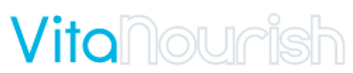

## NJOY
NJOY Apple Cider Vinegar Prebiotic Drinks: Delicious taste and essential nutrition, all in one guilt-free can!


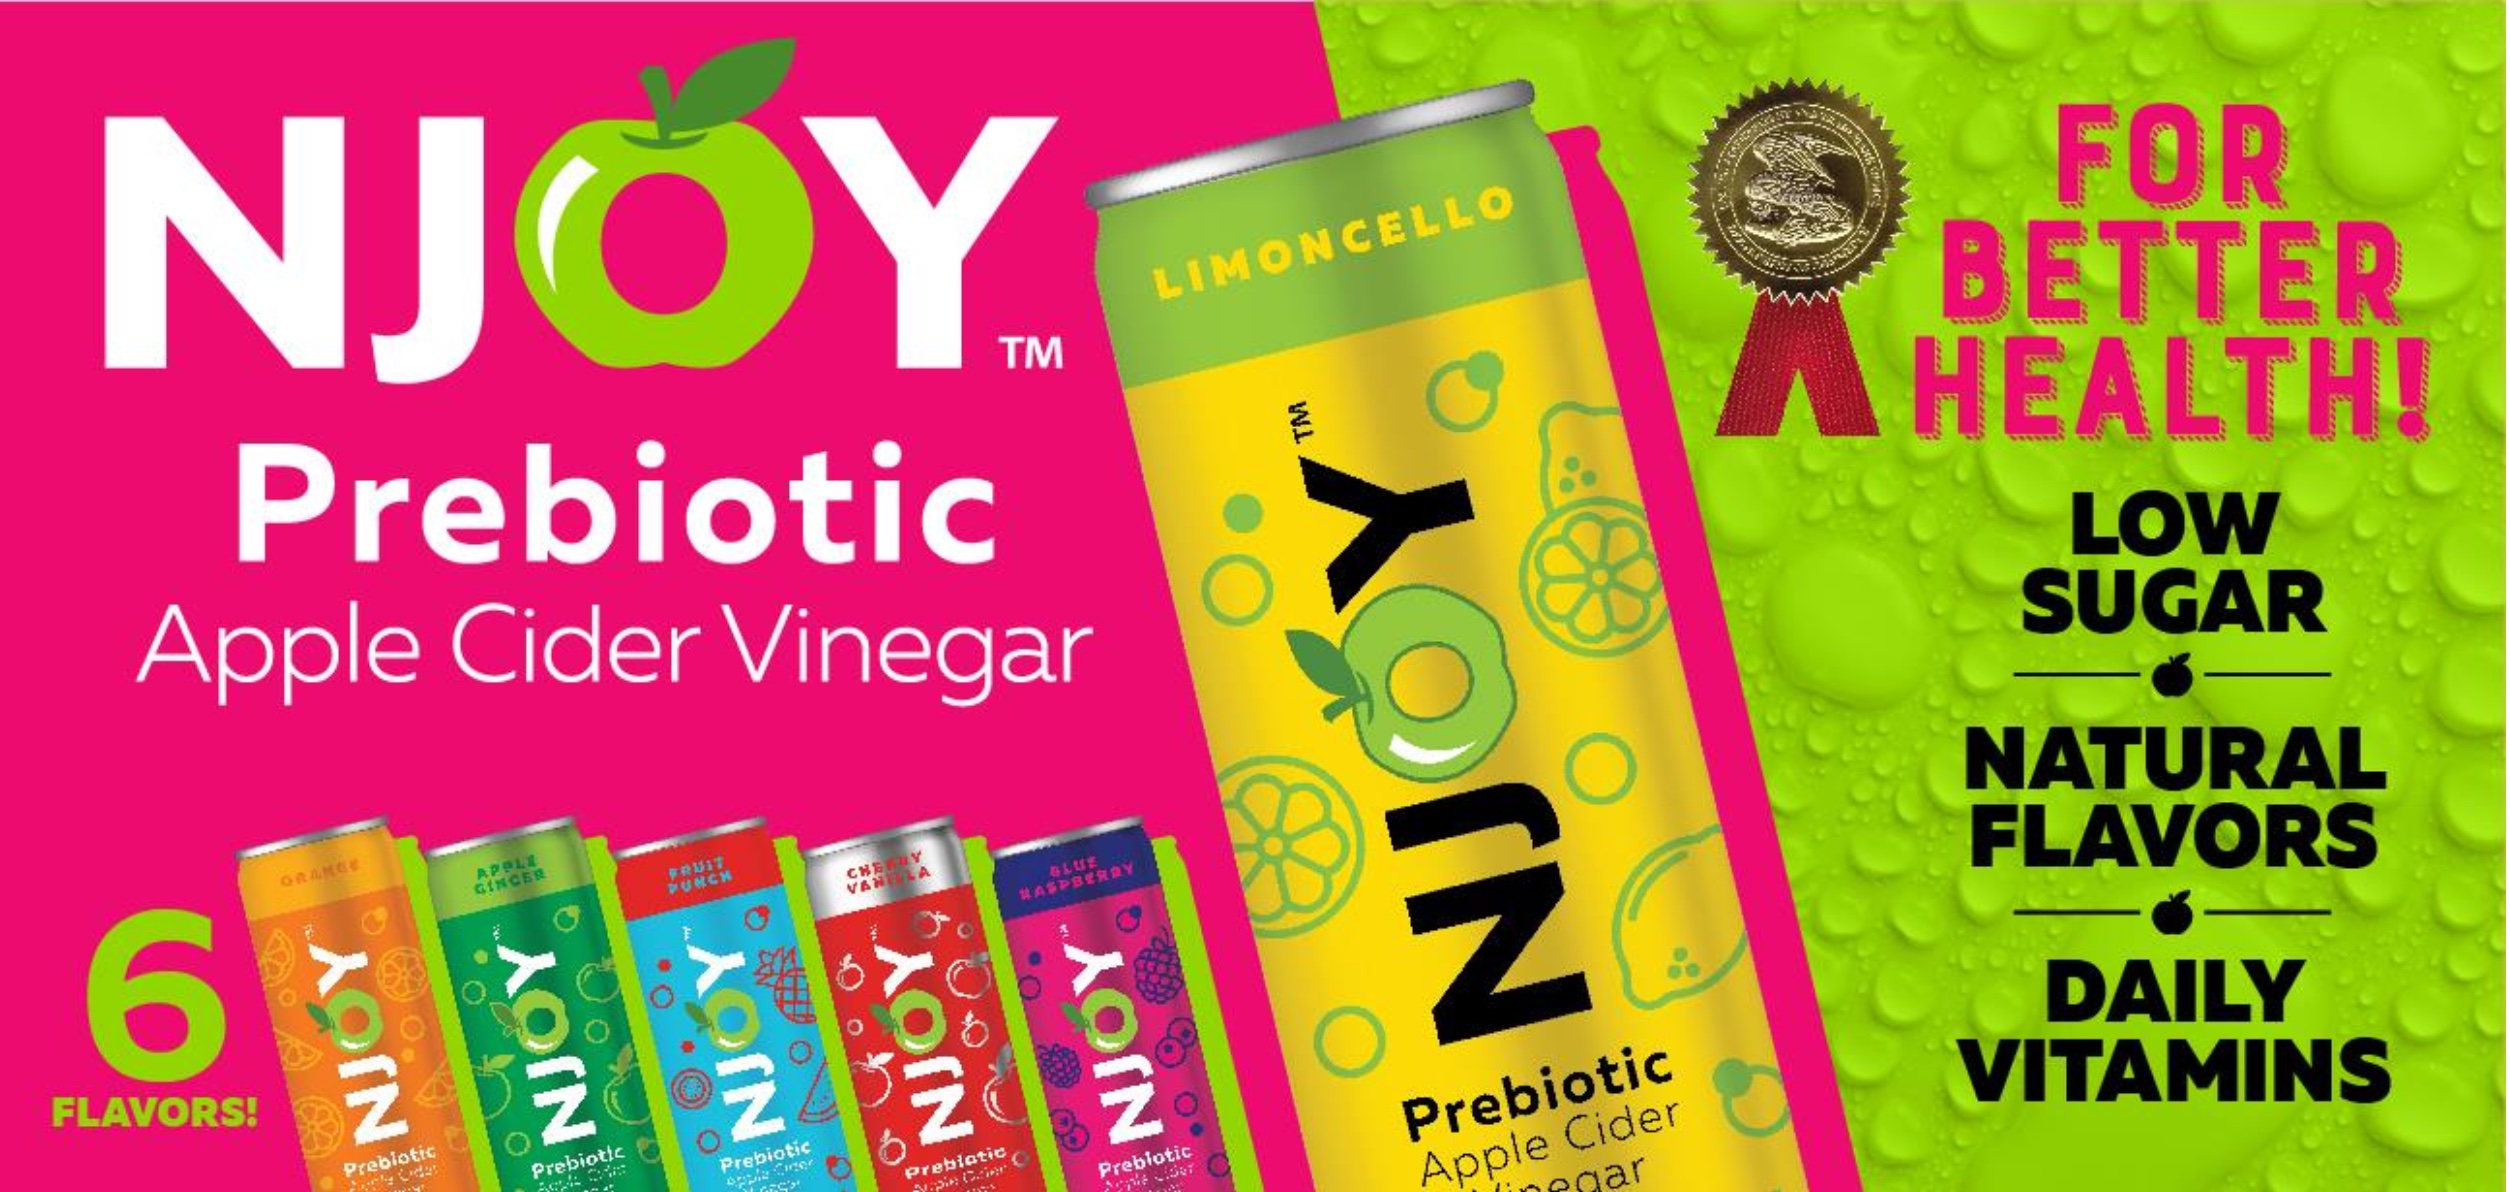

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "create a tagline or brief description of the product (NJOY Apple Cider prebiotic drinks)"
result = qa({"query": query})

In [ ]:
result['result']


# Cost Modeling & Due Dilligence

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "what data do we need to complete our models necessary to pass due dilliegence?"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
# Create a list to stuff section results into
cost_modeling = []

#append result  to the array
cost_modeling.append(result)

#print the array
print(cost_modeling)

In [ ]:
qa = VectorDBQA.from_chain_type(llm=OpenAI(), chain_type="stuff", vectorstore=docsearch, return_source_documents=True)
query = "Explain in depth What does EJ need to build a model? Use multiple quotes from eddie to support claims"
result = qa({"query": query})

In [ ]:
result['result']

In [ ]:
result['source_documents']